In [1]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

KeyError: 'CONDA_DEFAULT_ENV'

In [2]:
import torch
import numpy as np
import tensorly as tl
import scipy.signal
import scipy.io
import matplotlib.pyplot as plt
import sklearn.model_selection

import itertools

print(torch.cuda.is_available)
print(torch.cuda.device_count)
print(torch.cuda.current_device)
print(torch.cuda.get_device_name(0))

C:\Users\sabatini\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<function is_available at 0x0000018F564C8B80>
<function current_device at 0x0000018F5659CDC0>
Quadro P2000


In [3]:
import sys
sys.path.append(r'C:\Users\sabatini\Documents\GitHub')
%load_ext autoreload
%autoreload 2
from tensor_regression import multinomial_tensor_regression as mtr

import tensor_regression.util

In [718]:
labels = scipy.io.loadmat('C:/Users/sabatini/Documents/currtens/allLabels.mat', simplify_cells=True)['allLabels']
tensor = scipy.io.loadmat('C:/Users/sabatini/Documents/currtens/tensor.mat', simplify_cells=True)['tensor']
timepoints = scipy.io.loadmat('C:/Users/sabatini/Documents/currtens/timepoints_for_tensor.mat', simplify_cells=True)['timepoints_for_tensor']

# Load file_path
#file_path = r'C:\Users\sabatini\Documents\currtens\cpmlr.pkl'
#import pickle
#with open(file_path, 'rb') as f:
#    obj = pickle.load(f)
#Bcp_before = obj.return_Bcp_final()
# Show Bcp_before
#print(Bcp_before)
# Make Bcp_before a tensor
#torch.cuda.empty_cache()
#torch.cuda.memory.max_split_size_mb = 256  # setting it to 256MB
#DEVICE = tensor_regression.util.set_device(use_GPU=True)
#Bcp_before = torch.tensor(Bcp_before[0]).to(DEVICE)
# Make Bcp_forinit an iterable of the tensors Bcp_before
#Bcp_forinit = [Bcp_before]

In [719]:
print(f'Input data shapes:')
print(f'labels: {labels.shape}')
print(f'tensor: {tensor.shape}')
print(f'timepoints: {timepoints.shape}')

Input data shapes:
labels: (40,)
tensor: (1054, 450, 40)
timepoints: (450,)


(array([2420.,  670.,  510.,  410.,  330.,  320.,  520.,  550.,  480.,
         620.,  780.,  650.,  460.,  510.,  470.,  360.,  460.,  470.,
         510.,  470.,  450.,  340.,  220.,  260.,  150.,  200.,  150.,
         180.,  110.,  120.,  110.,  150.,  110.,  190.,  190.,  220.,
         140.,  100.,  100.,   80.,   80.,   60.,  100.,   40.,   80.,
          70.,   50.,  100.,   50.,   70.,  120.,   40.,   50.,   70.,
          60.,   80.,   80.,   60.,   50.,   40.,   50.,   40.,   50.,
          30.,   80.,   70.,   60.,   30.,   40.,   20.,   30.,   50.,
          50.,   20.,   40.,   20.,   10.,   10.,    0.,   20.,   30.,
          40.,   20.,   30.,   30.,   30.,   30.,   40.,   10.,   10.,
           0.,   10.,    0.,   20.,    0.,   20.,    0.,   20.,   20.,
          30.]),
 array([7.62588258e-17, 1.99974371e-02, 3.99948743e-02, 5.99923114e-02,
        7.99897486e-02, 9.99871857e-02, 1.19984623e-01, 1.39982060e-01,
        1.59979497e-01, 1.79976934e-01, 1.99974371e-01, 2.

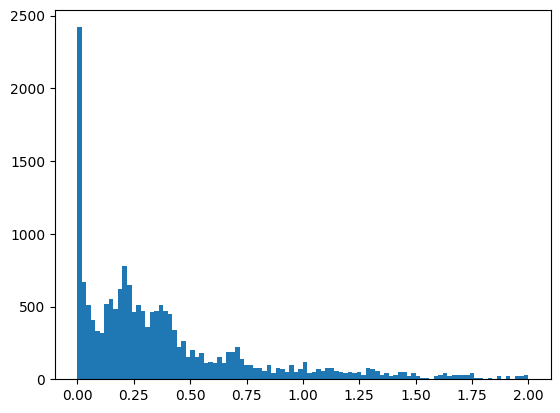

In [720]:
plt.figure()
plt.hist(tensor[0].reshape(-1), 100)

In [738]:
X = np.array(np.nan_to_num(tensor).transpose((2,0,1)), dtype=np.float32)
#X = (X - np.mean(X, axis=1)[:,None,:])
y = np.array(labels, dtype=np.int64)
print(f'X: {X.shape}, y: {y.shape}')

# y[y==1] = 0
# y[y>=2] = 1
# y[y==2] = 0
# y[y==3] = 1


DEVICE = tensor_regression.util.set_device(use_GPU=True)

u, c = np.unique(y, return_counts=True)
wei = c.sum() / c
wei = wei*4
print(wei)

hyperparameters = {}
hyperparameters['L2'] = [0.0125] #[0.0011] #[0.0125] #[0.0005] #[0.0, 0.001, 0.002, 0.004, 0.01, 0.02, 0.04]
hyperparameters['lr'] = [0.007] #[0.005] #[0.05] #[0.0003, 0.001, 0.003, 0.01, 0.03]
hyperparameters['rank'] = [2] #[4] #[1,2,3,4]
hyperparameters['Bcp_init_scale'] = [0.625] #[0.625] #[0.5, 1.0, 2.0]
hyperparameters['non_negative'] = [[True, False, False]] #[[True, True, True]] #[[False, False, False], [True, False, False], [False, True, False], [True, True, False]]
hyperparameters['iteration'] = list(np.arange(1)) #list(np.arange(5))

results = {}
for ii, h_vals in enumerate(itertools.product(*hyperparameters.values())):
    h_dict = {key: hv for key, hv in zip(hyperparameters.keys(), h_vals)}
    print(f'hyperparameters: {h_dict}')

    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.5, shuffle=True, stratify=y)

    cpmlr = mtr.CP_logistic_regression(
        X_train,
        y_train, 
        rank=h_dict['rank'],
        non_negative=h_dict['non_negative'],
        weights=None,
        Bcp_init=None,
        Bcp_init_scale=h_dict['Bcp_init_scale'],
        device=DEVICE,
        softplus_kwargs={
            'beta': 50,
            'threshold':1
        }
    )

    # cpmlr.fit(
    #     lambda_L2=0.000, 
    #     max_iter=200, 
    #     tol=1e-50, 
    #     patience=10,
    #     weights=weights,
    #     verbose=2,
    #     running_loss_logging_interval=1,
    #     LBFGS_kwargs={
    #         'lr' : 10000, 
    #         'max_iter' : 20, 
    #         'max_eval' : None, 
    #         'tolerance_grad' : 1e-07, 
    #         'tolerance_change' : 1e-09, 
    #         'history_size' : 100, 
    #         'line_search_fn' : "strong_wolfe"
    #     }
    #  )

    cpmlr.fit_Adam(
        lambda_L2=h_dict['L2'],
        max_iter=10000, 
        tol=1e-5, 
        patience=100,
        weights=wei,
        verbose=2,
        Adam_kwargs={
                'lr' : h_dict['lr'], 
    #                             'betas' : (0.9, 0.999), 
    #                             'eps' : 1e-08, 
    #                             'weight_decay' : 0, 
                'amsgrad' : True
            }
         )

    # # print(time.time() - tic)
    # print(f'loss: {cpmlr.loss_running[-1]}')

    # loss_all.append(cpmlr.loss_running[-1])

    logit, pred = cpmlr.predict(X=X_test, y_true=y_test)
    cm = mtr.confusion_matrix(pred, y_test)
    acc_val = np.sum(np.diag(cm))/np.sum(cm)

    logit, pred = cpmlr.predict(X=X_train, y_true=y_train)
    cm = mtr.confusion_matrix(pred, y_train)
    acc_train = np.sum(np.diag(cm))/np.sum(cm)

    # Make neuron- and time-shuffled data
    X_train_shuffled = X_train.copy()
    X_train_shuffled = X_train_shuffled[:, np.random.permutation(X_train_shuffled.shape[1]), :]
    X_train_shuffled = X_train_shuffled[:, :, np.random.permutation(X_train_shuffled.shape[2])]
    logit, pred = cpmlr.predict(X=X_train_shuffled, y_true=y_train)
    cm = mtr.confusion_matrix(pred, y_train)
    acc_train_shuffled = np.sum(np.diag(cm))/np.sum(cm)

    # Make trial-shuffled cm
    logit, pred = cpmlr.predict(X=X_train[np.random.permutation(X_train.shape[0])], y_true=y_train)
    cm = mtr.confusion_matrix(pred, y_train)
    acc_train_shuffled_trial = np.sum(np.diag(cm))/np.sum(cm)
    
    print(f'Accuracy test: {acc_val:.3f}, Accuracy train: {acc_train:.3f}, Accuracy neuron and time shuffled: {acc_train_shuffled:.3f}, Accuracy trial shuffled: {acc_train_shuffled_trial:.3f}')

    
    results[ii] = {}
    results[ii]['acc_val'] = acc_val
    results[ii]['acc_train'] = acc_train
    results[ii]['acc_train_shuffleNeurXTime'] = acc_train_shuffled
    results[ii]['acc_train_shuffleTrial'] = acc_train_shuffled_trial
    results[ii]['loss_running'] = cpmlr.loss_running
    results[ii]['loss_train_final'] = cpmlr.loss_running[-1]
    results[ii]['hyperparameters'] = h_dict


X: (40, 1054, 450), y: (40,)
device: 'cuda'
[16. 16. 16. 16.]
hyperparameters: {'L2': 0.0125, 'lr': 0.007, 'rank': 2, 'Bcp_init_scale': 0.625, 'non_negative': [True, False, False], 'iteration': 0}
Iteration: 0, Loss: 1.7739735841751099
Iteration: 1, Loss: 1.76804518699646
Iteration: 2, Loss: 1.7621650695800781
Iteration: 3, Loss: 1.7563366889953613
Iteration: 4, Loss: 1.7505741119384766
Iteration: 5, Loss: 1.744858741760254
Iteration: 6, Loss: 1.7391912937164307
Iteration: 7, Loss: 1.7335734367370605
Iteration: 8, Loss: 1.7280066013336182
Iteration: 9, Loss: 1.72249174118042
Iteration: 10, Loss: 1.7170305252075195
Iteration: 11, Loss: 1.7119977474212646
Iteration: 12, Loss: 1.7079226970672607
Iteration: 13, Loss: 1.7042500972747803
Iteration: 14, Loss: 1.7005997896194458
Iteration: 15, Loss: 1.6969681978225708
Iteration: 16, Loss: 1.693352460861206
Iteration: 17, Loss: 1.6897505521774292
Iteration: 18, Loss: 1.6861612796783447
Iteration: 19, Loss: 1.6825840473175049
Iteration: 20, Loss

Accuracy TRAIN: 0.5


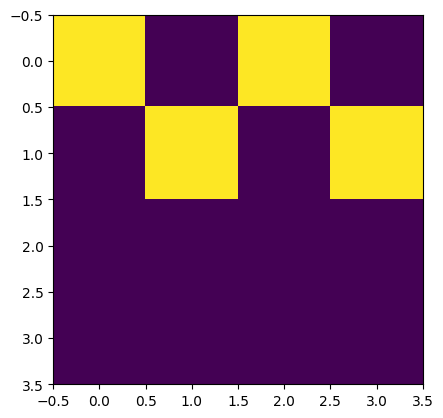

In [636]:
logit, pred = cpmlr.predict(X=X_train, y_true=y_train)
cm = mtr.confusion_matrix(pred, y_train)
acc = np.sum(np.diag(cm))/np.sum(cm)

print(f'Accuracy TRAIN: {acc}')

plt.figure()
plt.imshow(cm)

Accuracy TEST: 1.0


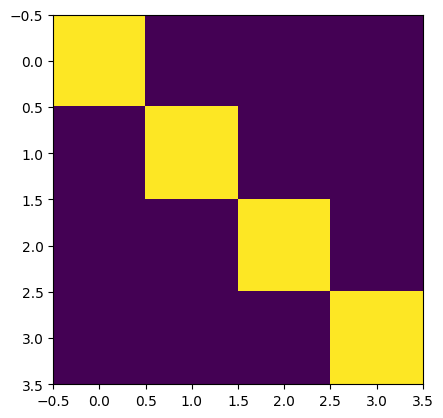

In [58]:
logit, pred = cpmlr.predict(X=X_test, y_true=y_test)
cm = mtr.confusion_matrix(pred, y_test)
acc = np.sum(np.diag(cm))/np.sum(cm)

print(f'Accuracy TEST: {acc}')

plt.figure()
plt.imshow(cm)

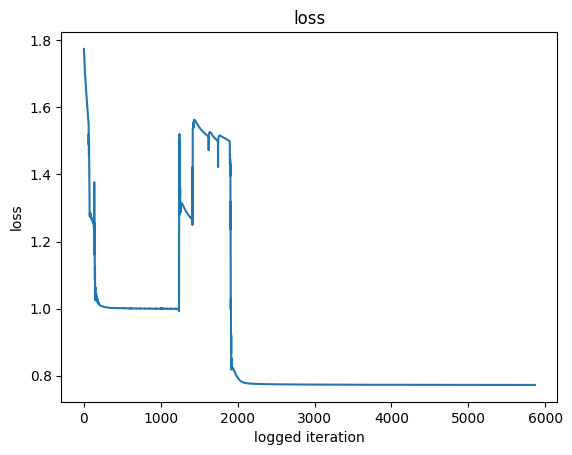

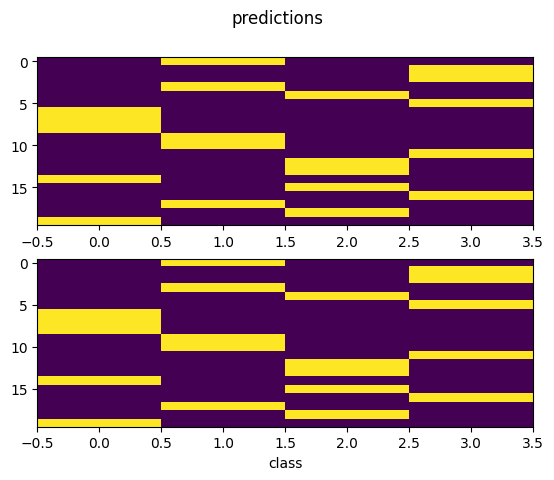

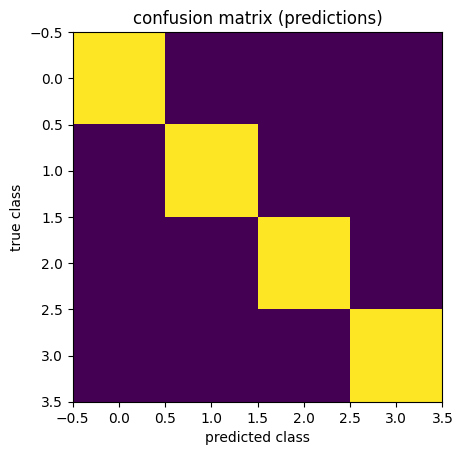

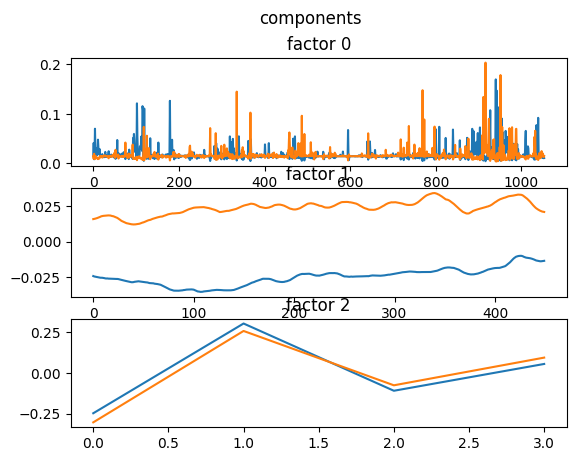

In [739]:
cpmlr.plot_outputs()

In [49]:
cpmlr.make_confusion_matrix()

(array([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]]),
 1.0)

In [6]:
import pickle

# Specify the file path to save the mdl
file_path = r'C:\Users\sabatini\Documents\currtens\cpmlr.pkl'

with open(file_path, 'wb') as file:
    # Save cpmlr
    pickle.dump(cpmlr, file)

print('cpmlr saved successfully.')

NameError: name 'cpmlr' is not defined

In [5]:
import os

# Save cpmlr to .mat file
file_path=r'C:\Users\sabatini\Documents\currtens'
Bcp_final = cpmlr.return_Bcp_final()
for ii, val in enumerate(Bcp_final):
    scipy.io.savemat(os.path.join(file_path, f'factor_{ii}.mat'), {'factor': val})
# Save hyperparameters
scipy.io.savemat(os.path.join(file_path, 'hyperparameters.mat'), {'hyperparameters': h_dict})
# Save results
# size of results
results_size = len(results)
print(results_size)
scipy.io.savemat(os.path.join(file_path, 'results.mat'), {'results': results[0]})

NameError: name 'cpmlr' is not defined

In [41]:
cpmlr.Bcp.cpu()

AttributeError: 'list' object has no attribute 'cpu'

In [141]:
labels = scipy.io.loadmat('C:/Users/sabatini/Documents/currtens BEST SO FAR/allLabels.mat', simplify_cells=True)['allLabels']
tensor = scipy.io.loadmat('C:/Users/sabatini/Documents/currtens BEST SO FAR/tensor.mat', simplify_cells=True)['tensor']
timepoints = scipy.io.loadmat('C:/Users/sabatini/Documents/currtens BEST SO FAR/timepoints_for_tensor.mat', simplify_cells=True)['timepoints_for_tensor']
# Load file_path
file_path = r'C:\Users\sabatini\Documents\currtens BEST SO FAR\cpmlr.pkl'
import pickle
with open(file_path, 'rb') as f:
    cpmlr = pickle.load(f)

Bcp_before = cpmlr.return_self()

print(dir(cpmlr))
#print(cpmlr.X)

#cpmlr2 = mtr.CP_logistic_regression(
#        cpmlr.X.cpu(),
#        cpmlr.y.cpu(), 
#        rank=cpmlr.rank,
#        non_negative=cpmlr.non_negative,
#        weights=cpmlr.weights.cpu(),
#        Bcp_init=[bcp.cpu() for bcp in cpmlr.Bcp],
#        Bcp_init_scale=0.625,
#        device='cpu',
#        softplus_kwargs={
#            'beta': 50,
#            'threshold':1
#        }
#    )

# Show Bcp_before
#print(Bcp_before)
# Make Bcp_before a tensor
#torch.cuda.empty_cache()
#torch.cuda.memory.max_split_size_mb = 256  # setting it to 256MB
#DEVICE = tensor_regression.util.set_device(use_GPU=True)
#Bcp_before = torch.tensor(Bcp_before[0]).to(DEVICE)
# Make Bcp_forinit an iterable of the tensors Bcp_before
#Bcp_forinit = [Bcp_before]

['Bcp', 'X', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slotnames__', '__str__', '__subclasshook__', '__weakref__', 'detach_Bcp', 'device', 'display_params', 'fit', 'fit_Adam', 'get_params', 'loss_running', 'make_confusion_matrix', 'n_classes', 'non_negative', 'plot_outputs', 'predict', 'rank', 'return_Bcp_final', 'return_self', 'set_params', 'softplus_kwargs', 'weights', 'y']


X: (204, 1054, 450), y: (204,)
Accuracy TEST: 0.9705882352941178


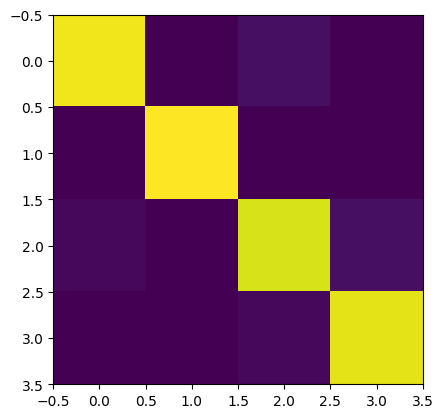

In [142]:
X = np.array(np.nan_to_num(tensor).transpose((2,0,1)), dtype=np.float32)
y = np.array(labels, dtype=np.int64)
print(f'X: {X.shape}, y: {y.shape}')

#X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.5, shuffle=True, stratify=y)

logit, pred = cpmlr.predict(X=torch.as_tensor(X), y_true=torch.as_tensor(y))

cm = mtr.confusion_matrix(pred, y)
acc = np.sum(np.diag(cm))/np.sum(cm)

print(f'Accuracy TEST: {acc}')

plt.figure()
plt.imshow(cm)

#print(logit)
#print(logit.sum(axis=1))

In [143]:
#old_cpmlr=[cpmlr]

#X = np.array(np.nan_to_num(tensor).transpose((2,0,1)), dtype=np.float32)
#X = (X - np.mean(X, axis=1)[:,None,:])
#y = np.array(labels, dtype=np.int64)
#print(f'X: {X.shape}, y: {y.shape}')

# y[y==1] = 0
# y[y>=2] = 1
# y[y==2] = 0
# y[y==3] = 1


DEVICE = tensor_regression.util.set_device(use_GPU=True)

u, c = np.unique(y, return_counts=True)
wei = c.sum() / c
wei = wei*4
print(wei)

hyperparameters = {}
hyperparameters['L2'] = [0.0125] #[0.0011] #[0.0125] #[0.0005] #[0.0, 0.001, 0.002, 0.004, 0.01, 0.02, 0.04]
hyperparameters['lr'] = [0.001] #[0.005] #[0.05] #[0.0003, 0.001, 0.003, 0.01, 0.03]
hyperparameters['rank'] = [4] #[4] #[1,2,3,4]
hyperparameters['Bcp_init_scale'] = [0.625] #[0.625] #[0.5, 1.0, 2.0]
hyperparameters['non_negative'] = [[True, False, False]] #[[True, True, True]] #[[False, False, False], [True, False, False], [False, True, False], [True, True, False]]
hyperparameters['iteration'] = list(np.arange(1)) #list(np.arange(5))

results = {}
for ii, h_vals in enumerate(itertools.product(*hyperparameters.values())):
    h_dict = {key: hv for key, hv in zip(hyperparameters.keys(), h_vals)}
    print(f'hyperparameters: {h_dict}')

    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.5, shuffle=True, stratify=y)

    cpmlr2 = mtr.CP_logistic_regression(
        X_train,
        y_train, 
        rank=h_dict['rank'],
        non_negative=h_dict['non_negative'],
        weights=None,
        Bcp_init=Bcp_before,
        Bcp_init_scale=h_dict['Bcp_init_scale'],
        device=DEVICE,
        softplus_kwargs={
            'beta': 50,
            'threshold':1
        }
    )

    # cpmlr.fit(
    #     lambda_L2=0.000, 
    #     max_iter=200, 
    #     tol=1e-50, 
    #     patience=10,
    #     weights=weights,
    #     verbose=2,
    #     running_loss_logging_interval=1,
    #     LBFGS_kwargs={
    #         'lr' : 10000, 
    #         'max_iter' : 20, 
    #         'max_eval' : None, 
    #         'tolerance_grad' : 1e-07, 
    #         'tolerance_change' : 1e-09, 
    #         'history_size' : 100, 
    #         'line_search_fn' : "strong_wolfe"
    #     }
    #  )

    cpmlr2.fit_Adam(
        lambda_L2=h_dict['L2'],
        max_iter=40000, 
        tol=1e-5, 
        patience=100,
        weights=wei,
        verbose=2,
        Adam_kwargs={
                'lr' : h_dict['lr'], 
    #                             'betas' : (0.9, 0.999), 
    #                             'eps' : 1e-08, 
    #                             'weight_decay' : 0, 
                'amsgrad' : True
            }
         )

    # # print(time.time() - tic)
    # print(f'loss: {cpmlr.loss_running[-1]}')

    # loss_all.append(cpmlr.loss_running[-1])

    logit, pred = cpmlr2.predict(X=X_test, y_true=y_test)
    cm = mtr.confusion_matrix(pred, y_test)
    acc_val = np.sum(np.diag(cm))/np.sum(cm)

    logit, pred = cpmlr2.predict(X=X_train, y_true=y_train)
    cm = mtr.confusion_matrix(pred, y_train)
    acc_train = np.sum(np.diag(cm))/np.sum(cm)

    # Make neuron- and time-shuffled data
    X_train_shuffled = X_train.copy()
    X_train_shuffled = X_train_shuffled[:, np.random.permutation(X_train_shuffled.shape[1]), :]
    X_train_shuffled = X_train_shuffled[:, :, np.random.permutation(X_train_shuffled.shape[2])]
    logit, pred = cpmlr2.predict(X=X_train_shuffled, y_true=y_train)
    cm = mtr.confusion_matrix(pred, y_train)
    acc_train_shuffled = np.sum(np.diag(cm))/np.sum(cm)

    # Make trial-shuffled cm
    logit, pred = cpmlr2.predict(X=X_train[np.random.permutation(X_train.shape[0])], y_true=y_train)
    cm = mtr.confusion_matrix(pred, y_train)
    acc_train_shuffled_trial = np.sum(np.diag(cm))/np.sum(cm)
    
    print(f'Accuracy test: {acc_val:.3f}, Accuracy train: {acc_train:.3f}, Accuracy neuron and time shuffled: {acc_train_shuffled:.3f}, Accuracy trial shuffled: {acc_train_shuffled_trial:.3f}')

    
    results[ii] = {}
    results[ii]['acc_val'] = acc_val
    results[ii]['acc_train'] = acc_train
    results[ii]['acc_train_shuffleNeurXTime'] = acc_train_shuffled
    results[ii]['acc_train_shuffleTrial'] = acc_train_shuffled_trial
    results[ii]['loss_running'] = cpmlr.loss_running
    results[ii]['loss_train_final'] = cpmlr.loss_running[-1]
    results[ii]['hyperparameters'] = h_dict

device: 'cuda'
[16. 16. 16. 16.]
hyperparameters: {'L2': 0.0125, 'lr': 0.001, 'rank': 4, 'Bcp_init_scale': 0.625, 'non_negative': [True, False, False], 'iteration': 0}
Iteration: 0, Loss: 1.8964509963989258
Iteration: 1, Loss: 1.8952456712722778
Iteration: 2, Loss: 1.8940417766571045
Iteration: 3, Loss: 1.8928391933441162
Iteration: 4, Loss: 1.8916380405426025
Iteration: 5, Loss: 1.890438437461853
Iteration: 6, Loss: 1.8892402648925781
Iteration: 7, Loss: 1.8880435228347778
Iteration: 8, Loss: 1.8868482112884521
Iteration: 9, Loss: 1.8856545686721802
Iteration: 10, Loss: 1.8844623565673828
Iteration: 11, Loss: 1.8832716941833496
Iteration: 12, Loss: 1.882082462310791
Iteration: 13, Loss: 1.8808948993682861
Iteration: 14, Loss: 1.8797088861465454
Iteration: 15, Loss: 1.8785243034362793
Iteration: 16, Loss: 1.877341389656067
Iteration: 17, Loss: 1.8761600255966187
Iteration: 18, Loss: 1.8749802112579346
Iteration: 19, Loss: 1.8738019466400146
Iteration: 20, Loss: 1.8726252317428589
Itera

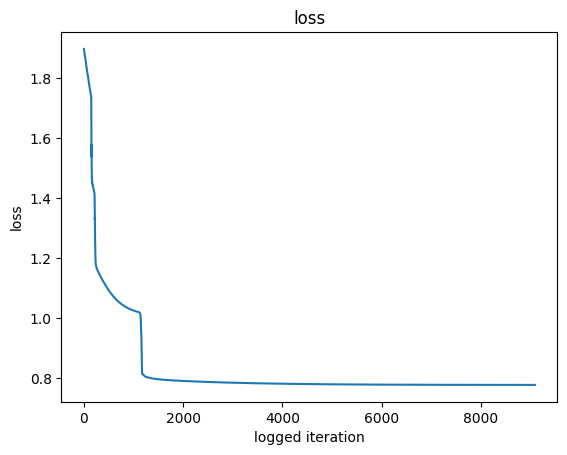

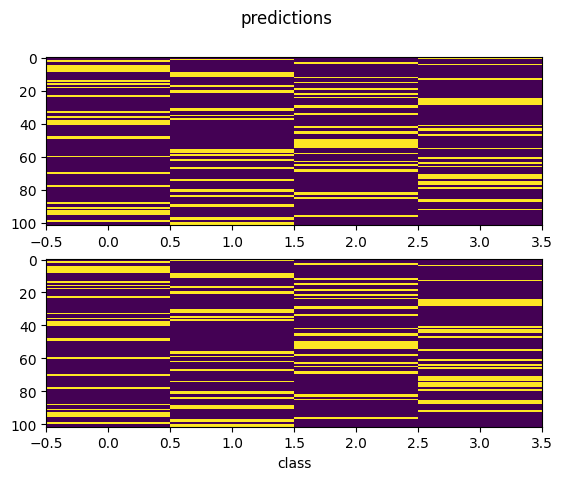

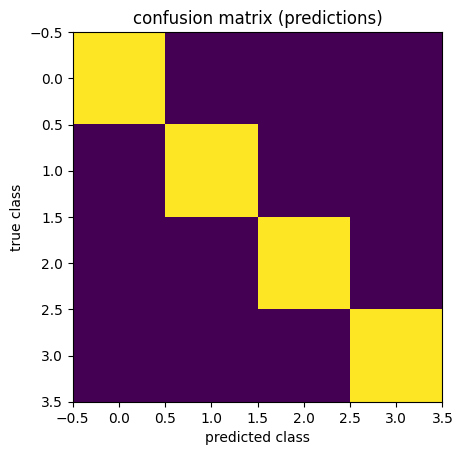

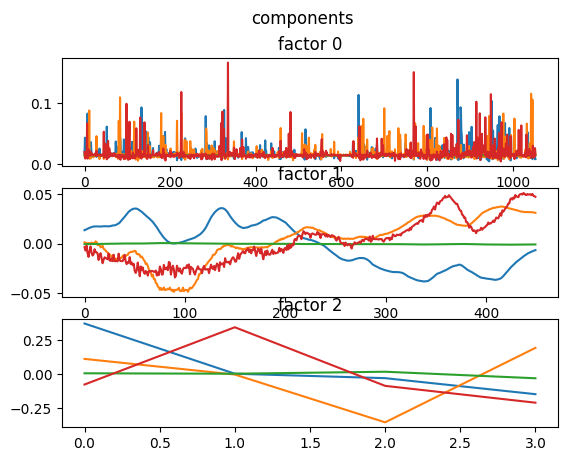

In [144]:
cpmlr2.plot_outputs()

In [123]:
import pickle

# Specify the file path to save the mdl
file_path = r'C:\Users\sabatini\Documents\currtens2\cpmlr.pkl'

with open(file_path, 'wb') as file:
    # Save cpmlr
    pickle.dump(cpmlr2, file)

print('cpmlr2 saved successfully.')

cpmlr2 saved successfully.


In [124]:
import os

# Save cpmlr to .mat file
file_path=r'C:\Users\sabatini\Documents\currtens2'
Bcp_final = cpmlr2.return_Bcp_final()
for ii, val in enumerate(Bcp_final):
    scipy.io.savemat(os.path.join(file_path, f'factor_{ii}.mat'), {'factor': val})

In [405]:
h_dict['lr']=0.008

cpmlr.fit_Adam(
        lambda_L2=h_dict['L2'],
        max_iter=40000, 
        tol=1e-5, 
        patience=100,
        weights=wei,
        verbose=2,
        Adam_kwargs={
                'lr' : h_dict['lr'], 
    #                             'betas' : (0.9, 0.999), 
    #                             'eps' : 1e-08, 
    #                             'weight_decay' : 0, 
                'amsgrad' : True
            }
         )

Iteration: 0, Loss: 0.7798802852630615
Iteration: 1, Loss: 0.8037784099578857
Iteration: 2, Loss: 1.51091468334198
Iteration: 3, Loss: 1.5058146715164185
Iteration: 4, Loss: 1.523882508277893
Iteration: 5, Loss: 1.514397382736206
Iteration: 6, Loss: 1.5248479843139648
Iteration: 7, Loss: 1.5266633033752441
Iteration: 8, Loss: 1.5272153615951538
Iteration: 9, Loss: 1.5274019241333008
Iteration: 10, Loss: 1.5273113250732422
Iteration: 11, Loss: 1.5267753601074219
Iteration: 12, Loss: 1.5248000621795654
Iteration: 13, Loss: 1.5156900882720947
Iteration: 14, Loss: 1.520105242729187
Iteration: 15, Loss: 1.52554452419281
Iteration: 16, Loss: 1.526480793952942
Iteration: 17, Loss: 1.5264793634414673
Iteration: 18, Loss: 1.5258527994155884
Iteration: 19, Loss: 1.5236202478408813
Iteration: 20, Loss: 1.513755440711975
Iteration: 21, Loss: 1.519263505935669
Iteration: 22, Loss: 1.524715542793274
Iteration: 23, Loss: 1.5256692171096802
Iteration: 24, Loss: 1.525391936302185
Iteration: 25, Loss: 1

KeyboardInterrupt: 

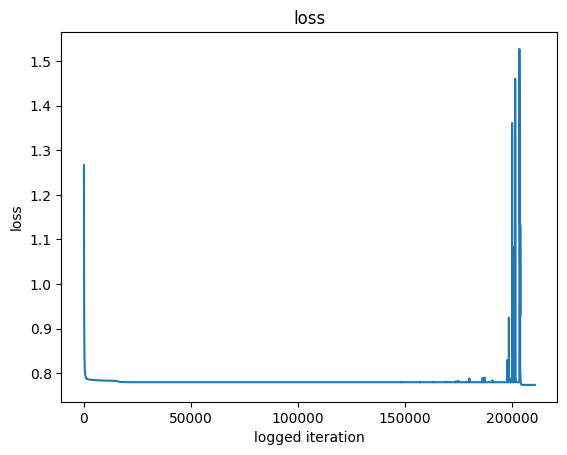

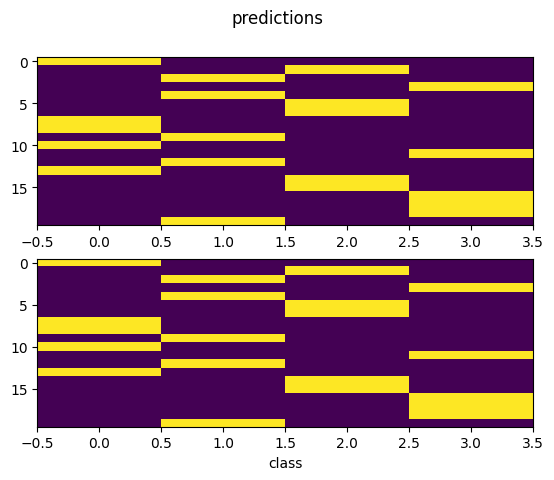

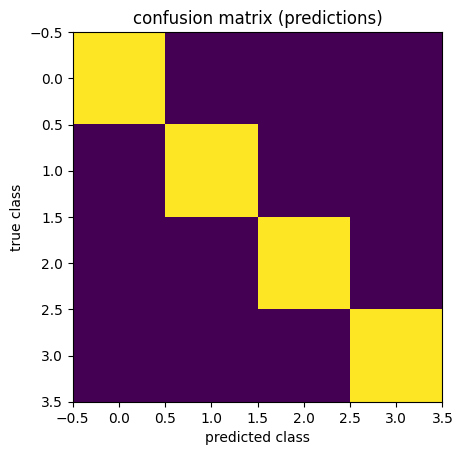

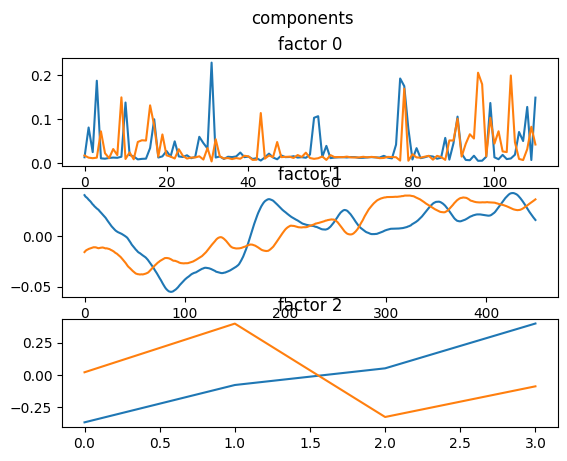

In [406]:
cpmlr.plot_outputs()

In [407]:
import pickle

# Specify the file path to save the mdl
file_path = r'C:\Users\sabatini\Documents\currtens2\cpmlr.pkl'

with open(file_path, 'wb') as file:
    # Save cpmlr
    pickle.dump(cpmlr, file)

print('cpmlr saved successfully.')

cpmlr saved successfully.


In [408]:
import os

# Save cpmlr to .mat file
file_path=r'C:\Users\sabatini\Documents\currtens2'
Bcp_final = cpmlr.return_Bcp_final()
for ii, val in enumerate(Bcp_final):
    scipy.io.savemat(os.path.join(file_path, f'factor_{ii}.mat'), {'factor': val})

In [409]:
cpmlr.make_confusion_matrix()

(array([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]]),
 1.0)